# Notebook for Geospatial Analysis and water quality analysis of river.

### In this notebook we will take HSI images and use it to analyze the 3 month chang in water quality and its properties in a river or any other water body.

The process will be breoadly divided into two parts where we first plot the heatmatp of latest images and find out the current status of the waterboadies and In second part we will identify the change in the water properties for a stretch of 3 month and find out how its water index changed, its soil index changed and how it mineral property like iron oxide and vegetation index changed. 


## Part 1

In this part our major lookout will be to identfy any kind of anomaly and non uniform distribution and flow of water in the water body. We will start here by importing required liberaries and importing images and normalizing them so that it will be ready to be analyzed uniformly.

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

# Suppress all warnings
warnings.filterwarnings('ignore')

# Function to read Sentinel-2 band
def read_band(band_path):
    with rasterio.open(band_path) as src:
        return src.read(1).astype(np.float32) / 10000  # Normalize

Here we will define function to select the latest available image by date time and then load that image, also we will add a condition to handle any errors

In [ ]:
# Function to extract date from filename (assuming format MM-DDBand_(Raw).tiff)
#def extract_date(filename):
   # parts = filename.split('B')
   # if len(parts) > 1 and len(parts[0]) == 5 and parts[0][2] == '-':  # Format is "MM-DD"
     #   return datetime.strptime(parts[0], "%m-%d")
    # return None

from datetime import datetime

def extract_date(filename):
    try:
        # Extract MM-DD from the start of the filename
        date_str = filename[:5]  # '03-11'
        return datetime.strptime(date_str, '%m-%d')
    except:
        return None


# Scan folder for TIFF files and find the latest date
folder_path = r"C:\Users\porje\OneDrive\Desktop\DS workshop\new" # Current directory, change if files are in another folder
tiff_files = [f for f in os.listdir(folder_path) if f.endswith('_(Raw).tiff')]

# Extract dates from filenames
dates = []
for file in tiff_files:
    date = extract_date(file)
    if date:
        dates.append((date, file))

# Sort dates to find the latest
if not dates:
    raise ValueError("No valid TIFF files found in the folder.")

latest_date, _ = max(dates, key=lambda x: x[0])
print(f"Latest date found: {latest_date.strftime('%m-%d')}")

# Construct band paths for the latest date
latest_date_str = latest_date.strftime('%m-%d')
band_paths = {
    "B2": f"{latest_date_str}B02_(Raw).tiff",
    "B4": f"{latest_date_str}B04_(Raw).tiff",
    "B8": f"{latest_date_str}B08_(Raw).tiff",
    "B11": f"{latest_date_str}B11_(Raw).tiff"
}

# Load data for the latest date
data = {}
for key, path in band_paths.items():
    if os.path.exists(path):
        try:
            data[key] = read_band(path)
            print(f"Loaded {path}")
        except Exception as e:
            print(f"Error loading {key}: {e}")
            data[key] = None  # Mark as missing if there's an error
    else:
        print(f"File not found: {path}")
        data[key] = None  # Mark as missing if file doesn't exist

# Check if all bands are loaded (look for None values)
if any(v is None for v in data.values()):
    missing_bands = [k for k, v in data.items() if v is None]
    raise ValueError(f"Some bands for the latest date are missing or failed to load: {missing_bands}. Check file names and presence.")

Latest date found: 12-21
File not found: 12-21B02_(Raw).tiff
File not found: 12-21B04_(Raw).tiff
File not found: 12-21B08_(Raw).tiff
File not found: 12-21B11_(Raw).tiff


ValueError: Some bands for the latest date are missing or failed to load: ['B2', 'B4', 'B8', 'B11']. Check file names and presence.

In [6]:
import os
import rasterio
from datetime import datetime

# Function to extract MM-DD from filename
def extract_date(filename):
    try:
        date_str = filename[:5]  # 'MM-DD'
        return datetime.strptime(date_str, '%m-%d')
    except:
        return None

# Function to read a TIFF band
def read_band(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1).astype('float32')

# Set your folder path where TIFF files are stored
folder_path = r"C:\Users\porje\OneDrive\Desktop\DS workshop\new"

# List all TIFF files
tiff_files = [f for f in os.listdir(folder_path) if f.endswith('_(Raw).tiff')]

# Extract dates from filenames
dates = []
for file in tiff_files:
    date = extract_date(file)
    if date:
        dates.append((date, file))

# Find latest date
if not dates:
    raise ValueError("No valid TIFF files found in the folder.")

latest_date, _ = max(dates, key=lambda x: x[0])
print(f"✅ Latest date found: {latest_date.strftime('%m-%d')}")

# Construct filenames for the required bands
latest_date_str = latest_date.strftime('%m-%d')
band_paths = {
    "B2": f"{latest_date_str}B02_(Raw).tiff",
    "B4": f"{latest_date_str}B04_(Raw).tiff",
    "B8": f"{latest_date_str}B08_(Raw).tiff",
    "B11": f"{latest_date_str}B11_(Raw).tiff"
}

# Load bands into a dictionary
data = {}
for band, filename in band_paths.items():
    full_path = os.path.join(folder_path, filename)
    if os.path.exists(full_path):
        try:
            data[band] = read_band(full_path)
            print(f"✅ Loaded: {filename}")
        except Exception as e:
            print(f"❌ Error loading {filename}: {e}")
            data[band] = None
    else:
        print(f"❌ File not found: {filename}")
        data[band] = None

# Final check
missing = [k for k, v in data.items() if v is None]
if missing:
    raise ValueError(f"Some bands for the latest date are missing or failed to load: {missing}")


✅ Latest date found: 12-21
✅ Loaded: 12-21B02_(Raw).tiff
✅ Loaded: 12-21B04_(Raw).tiff
✅ Loaded: 12-21B08_(Raw).tiff
✅ Loaded: 12-21B11_(Raw).tiff


 Here we will compute the required Indices which are NDVI, NDWI, BSI, IOI for which we have already downloaded the required images.

In [7]:
# Compute indices safely
def safe_divide(numerator, denominator):
    return np.where(denominator == 0, np.nan, numerator / denominator)

ndvi = safe_divide(data["B8"] - data["B4"], data["B8"] + data["B4"])
ndwi = safe_divide(data["B8"] - data["B11"], data["B8"] + data["B11"])
bsi = safe_divide((data["B11"] + data["B4"]) - (data["B8"] + data["B2"]), 
                  (data["B11"] + data["B4"]) + (data["B8"] + data["B2"]))
ioi = safe_divide(data["B4"] + data["B8"], data["B4"] - data["B8"])

In [8]:
# Residue Index = SWIR / NIR = B11 / B08
B11 = data['B11'].astype('float32')
B08 = data['B8'].astype('float32')

# Avoid division by zero
B08[B08 == 0] = 0.01

# Compute the residue index
residue_index = B11 / B08


Plotting the heatmap.

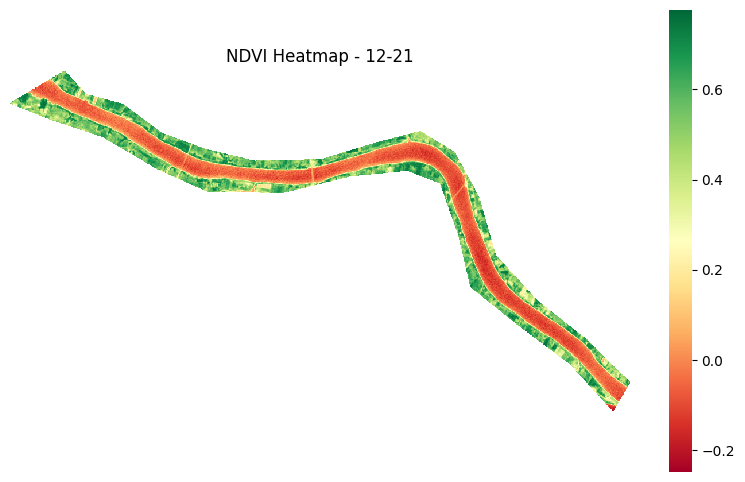

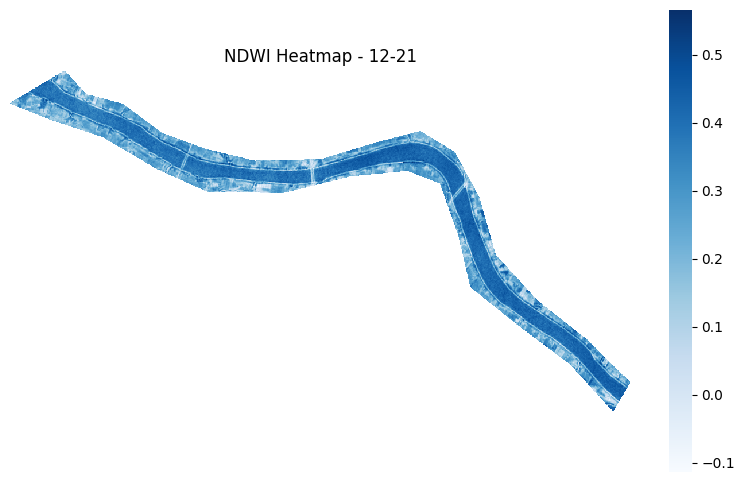

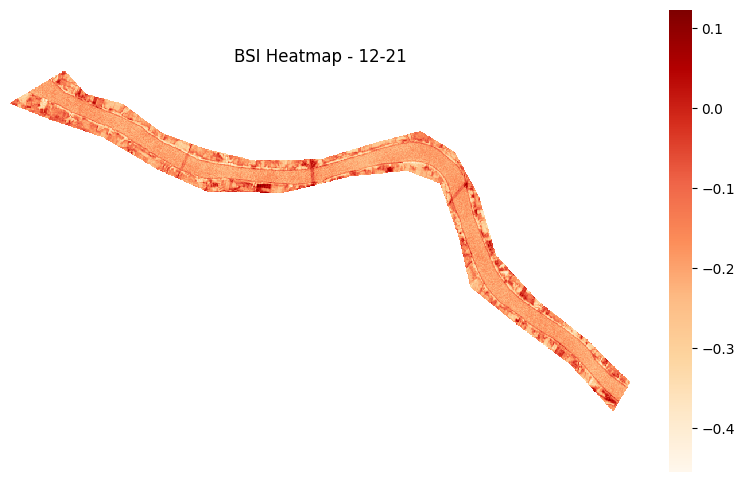

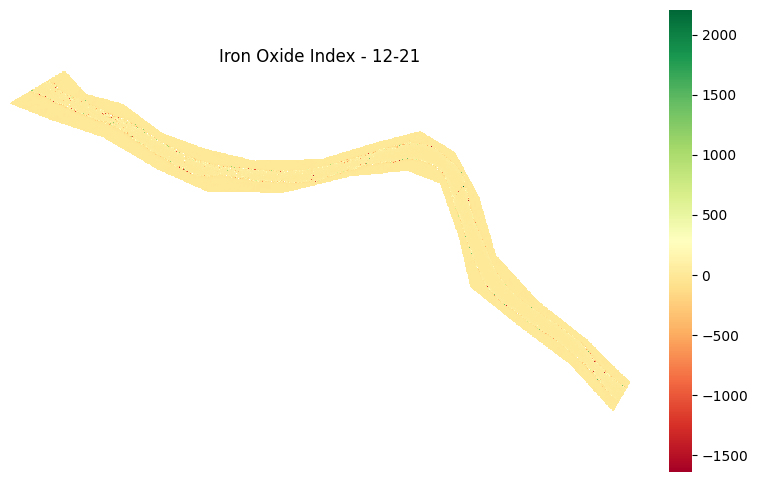

In [9]:
# Function to plot heatmap
def plot_heatmap(index, title, cmap):
    plt.figure(figsize=(10, 6))
    sns.heatmap(index, cmap=cmap, cbar=True, square=True, xticklabels=False, yticklabels=False)
    plt.title(f"{title} - {latest_date_str}")
    plt.show()

# Generate heatmaps for the latest date
plot_heatmap(ndvi, "NDVI Heatmap", cmap="RdYlGn")  # Green for vegetation
plot_heatmap(ndwi, "NDWI Heatmap", cmap="Blues")  # Blue for water content
plot_heatmap(bsi, "BSI Heatmap", cmap="OrRd")  # Orange for bare soil
plot_heatmap(ioi, "Iron Oxide Index", cmap="RdYlGn")  # RedGreen for iron oxide

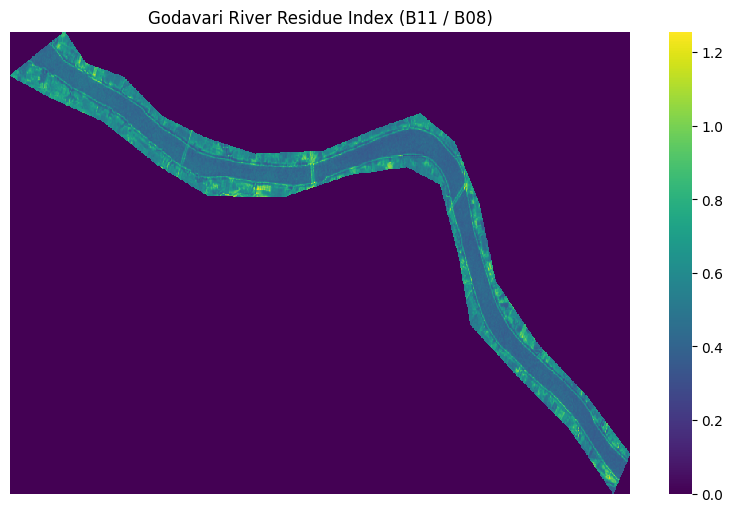

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(residue_index, cmap='viridis')
plt.title("Godavari River Residue Index (B11 / B08)")
plt.axis('off')
plt.show()


Residue index stats → min: 0.0 max: 1.2561576 mean: 0.06439553


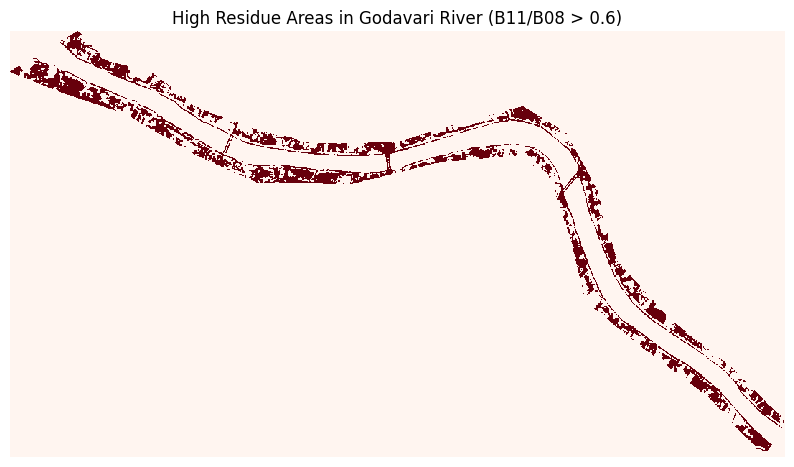

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Set a better threshold by analyzing values
print("Residue index stats → min:", np.min(residue_index), "max:", np.max(residue_index), "mean:", np.mean(residue_index))

# Try a lower threshold if values are small
threshold = 0.6  # Previously it might have been 1.5, which is too high

# Create high-residue mask
high_residue_mask = residue_index > threshold

# Plot the high residue mask more visibly
plt.figure(figsize=(10, 6))
plt.imshow(high_residue_mask, cmap='Reds', interpolation='nearest')
plt.title("High Residue Areas in Godavari River (B11/B08 > 0.6)")
plt.axis('off')
plt.show()



### 🔍 Residue Index Analysis Summary

- The Residue Index (B11 / B08) was used to detect **turbidity and suspended matter** in the Godavari River.
- Areas with index values above **0.6** are highlighted in red.
- These may indicate **pollution hotspots**, **industrial discharge**, or **natural sedimentation**.
- This analysis supports water quality assessment for environmental and civil planning.




# Part 2

Here we will load the images of 3 months basically having an interval of 10-15 days in between and calculate the values of required indices and then plot them on graph to find out the change and to simplify it we will plot a graph to see how the values change and what is the mean value of each indices

We will start again by importing required dependencies and importing the images

In [13]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
import scipy.stats as stats

# Suppress warnings
warnings.filterwarnings('ignore')

# Function to read Sentinel-2 band and return shape
def read_band(band_path):
    with rasterio.open(band_path) as src:
        return src.read(1).astype(np.float32) / 10000  # Normalize

Function to compute indices and using safe division to handle errors like division by 0

In [14]:
base_path = r"C:\Users\porje\OneDrive\Desktop\DS workshop\new"

In [15]:
def compute_indices(data):
    # Print keys and shapes for debugging (optional, remove if not needed)
    print("Keys in data:", data.keys())
    for key, arr in data.items():
        print(f"Shape of {key}: {arr.shape}")

    # Check if all arrays have the same shape
    shapes = [arr.shape for arr in data.values()]
    if not all(shape == shapes[0] for shape in shapes):
        raise ValueError(f"Shape mismatch in bands: {shapes}")

    # Compute indices using correct keys
    ndvi = safe_divide(data["B08"] - data["B04"], data["B08"] + data["B04"])
    ndwi = safe_divide(data["B08"] - data["B11"], data["B08"] + data["B11"])
    bsi = safe_divide((data["B11"] + data["B04"]) - (data["B08"] + data["B02"]), 
                      (data["B11"] + data["B04"]) + (data["B08"] + data["B02"]))
    ioi = safe_divide(data["B04"] + data["B08"], data["B04"] - data["B08"])
    return ndvi, ndwi, bsi, ioi

# Safe division
def safe_divide(numerator, denominator):
    return np.where(denominator == 0, np.nan, numerator / denominator)

Defining dates, Indices and naming structure of the files so that the key dictionary created will be accurate and according to the requirments.

In [16]:
# Define dates (month-day) based on your previous output
dates = [
    "01-10","01-30", "02-04" , "02-24", "03-01", "03-31", "12-21", "11-21"
]

# Initialize dictionaries to store index values over time
index_values = {
    "NDVI": [],
    "NDWI": [],
    "BSI": [],
    "IOI": []
}

# Bands to process
bands = ["B02", "B04", "B08", "B11"]

# Process each date
for date in dates:
    band_paths = {band: os.path.join(base_path, f"{date}{band}_(Raw).tiff") for band in bands} # e.g., "01-03B02_(Raw).tiff"

    data = {}
    # Load bands
    for key, path in band_paths.items():
        if os.path.exists(path):  # Check if file exists
            try:
                data[key] = read_band(path)
                print(f"Loaded {path} with key {key}, shape: {data[key].shape}")
            except Exception as e:
                print(f"Error loading {key} for {date}: {e}")
        else:
            print(f"File not found: {path}")

    # Ensure all bands are loaded and have the same shape
    if len(data) == 4:
        try:
            # Compute indices
            ndvi, ndwi, bsi, ioi = compute_indices(data)

            # Store mean values (ignoring NaN)
            index_values["NDVI"].append(np.nanmean(ndvi))
            index_values["NDWI"].append(np.nanmean(ndwi))
            index_values["BSI"].append(np.nanmean(bsi))
            index_values["IOI"].append(np.nanmean(ioi))
        except (ValueError, KeyError) as e:
            print(f"Error processing {date}: {e}")
    else:
        print(f"Skipping {date}: Not all bands loaded. Loaded {len(data)} out of 4.")




Loaded C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-10B02_(Raw).tiff with key B02, shape: (611, 1147)
Loaded C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-10B04_(Raw).tiff with key B04, shape: (611, 1147)
Loaded C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-10B08_(Raw).tiff with key B08, shape: (611, 1147)
File not found: C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-10B11_(Raw).tiff
Skipping 01-10: Not all bands loaded. Loaded 3 out of 4.
Loaded C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-30B02_(Raw).tiff with key B02, shape: (593, 1080)
Loaded C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-30B04_(Raw).tiff with key B04, shape: (593, 1080)
Loaded C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-30B08_(Raw).tiff with key B08, shape: (593, 1080)
Loaded C:\Users\porje\OneDrive\Desktop\DS workshop\new\01-30B11_(Raw).tiff with key B11, shape: (593, 1080)
Keys in data: dict_keys(['B02', 'B04', 'B08', 'B11'])
Shape of B02: (593, 1080)
Shape of B04: (593, 108

Converting dates and other info into numerical data and preparing the dataset for plotting graphs and other information.

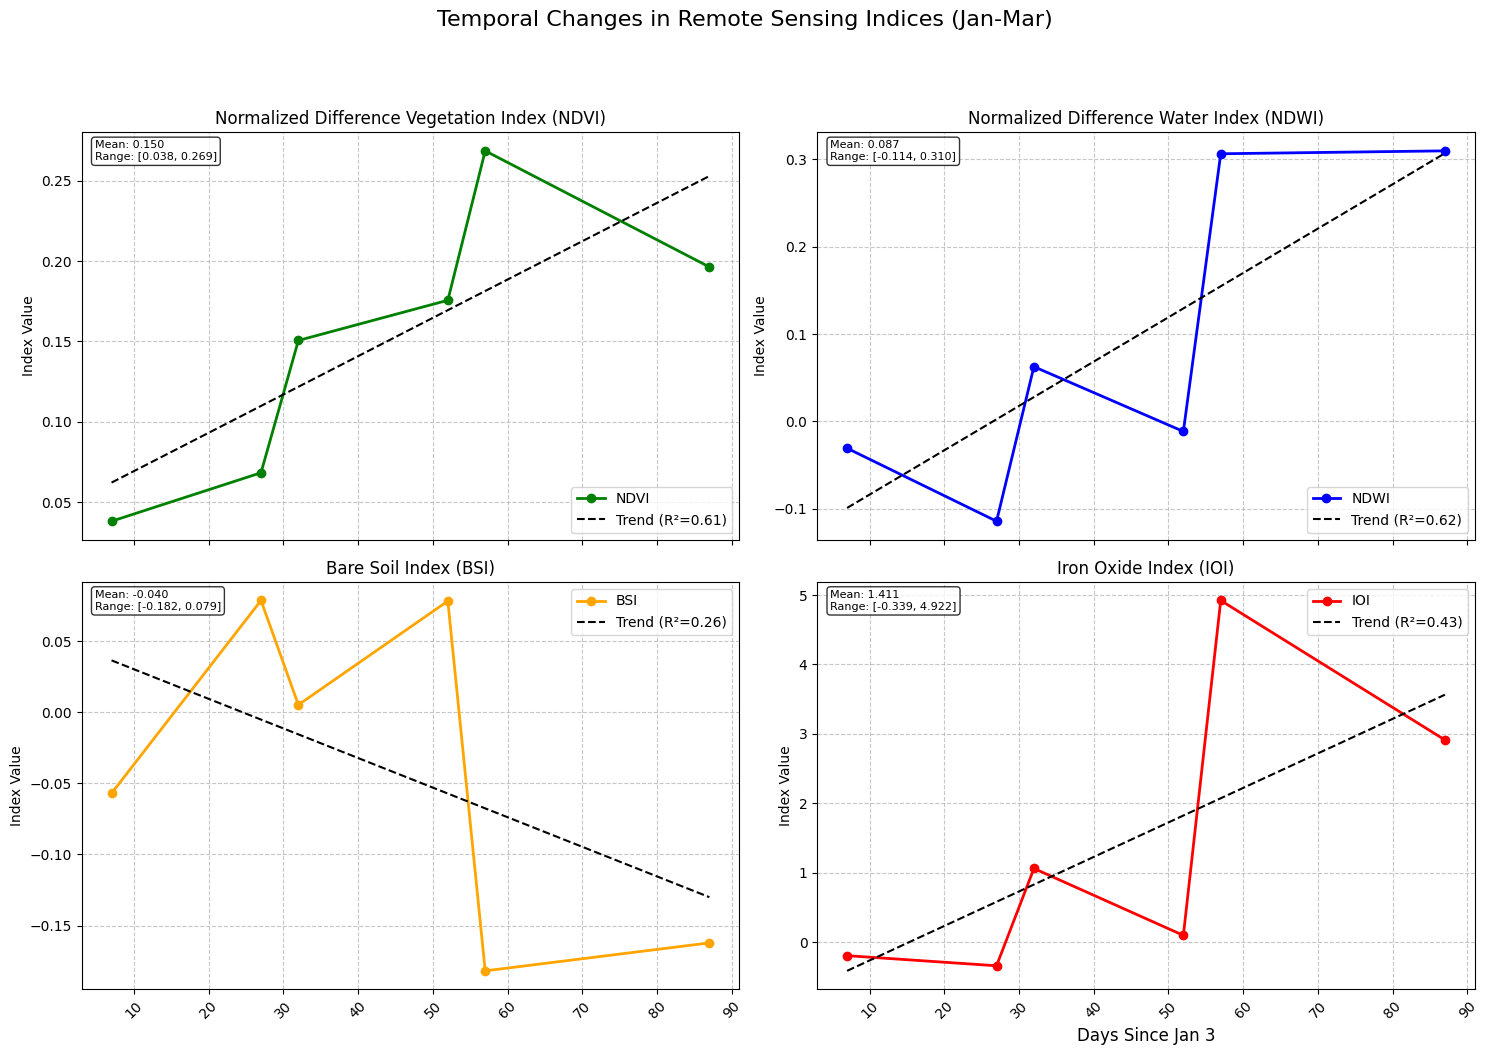

In [17]:
# Convert dates to numerical format for plotting (days since start)
start_date = datetime(2025, 1, 3)
date_nums = [datetime.strptime(d, "%m-%d").replace(year=2025) - start_date for d in dates]
date_nums = [d.days for d in date_nums]

# Create separate plots for each index
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
fig.suptitle("Temporal Changes in Remote Sensing Indices (Jan-Mar)", fontsize=16, y=1.05)

# Indices and their plots
indices = {
    "NDVI": {"ax": axs[0, 0], "color": "green", "title": "Normalized Difference Vegetation Index (NDVI)"},
    "NDWI": {"ax": axs[0, 1], "color": "blue", "title": "Normalized Difference Water Index (NDWI)"},
    "BSI": {"ax": axs[1, 0], "color": "orange", "title": "Bare Soil Index (BSI)"},
    "IOI": {"ax": axs[1, 1], "color": "red", "title": "Iron Oxide Index (IOI)"}
}

for index_name, params in indices.items():
    ax = params["ax"]
    color = params["color"]
    title = params["title"]

    if index_values[index_name]:  # Only plot if there are values
        # Plot data
        ax.plot(date_nums[:len(index_values[index_name])], index_values[index_name], 
                marker='o', color=color, linewidth=2, label=index_name)

        # Fit a linear trend line
        slope, intercept, r_value, p_value, std_err = stats.linregress(date_nums[:len(index_values[index_name])], 
                                                                      index_values[index_name])
        trend_line = [slope * x + intercept for x in date_nums[:len(index_values[index_name])]]
        ax.plot(date_nums[:len(index_values[index_name])], trend_line, color='k', linestyle='--', 
                label=f'Trend (R²={r_value**2:.2f})')

        # Customize each subplot
        ax.set_title(title, fontsize=12)
        ax.set_ylabel("Index Value", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

        # Add mean and range as text
        mean_val = np.nanmean(index_values[index_name])
        min_val, max_val = np.nanmin(index_values[index_name]), np.nanmax(index_values[index_name])
        ax.text(0.02, 0.98, f'Mean: {mean_val:.3f}\nRange: [{min_val:.3f}, {max_val:.3f}]', 
                transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set common x-label
plt.xlabel("Days Since Jan 3", fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

This is an optional step when you also want to display the numerical values

In [18]:
# Optional: Print summary
print("\nSummary of Index Changes:")
for index_name, values in index_values.items():
    if values:  # Check if there are any values
        print(f"{index_name}: Start = {values[0]:.4f}, End = {values[-1]:.4f}, Change = {values[-1] - values[0]:.4f}, Mean = {np.nanmean(values):.4f}")
    else:
        print(f"{index_name}: No data available")


Summary of Index Changes:
NDVI: Start = 0.0380, End = 0.1964, Change = 0.1584, Mean = 0.1496
NDWI: Start = -0.0308, End = 0.3098, Change = 0.3406, Mean = 0.0870
BSI: Start = -0.0570, End = -0.1622, Change = -0.1052, Mean = -0.0398
IOI: Start = -0.1932, End = 2.9132, Change = 3.1065, Mean = 1.4107


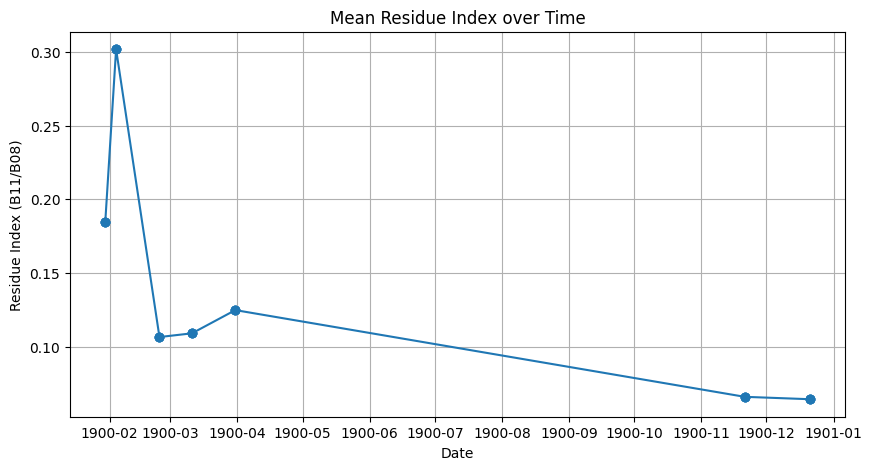

In [20]:
import pandas as pd

# Store mean residue index for each date
residue_summary = []

for filename in sorted(tiff_files):
    date = extract_date(filename)
    if not date:
        continue

    date_str = date.strftime('%m-%d')
    b8_path = os.path.join(folder_path, f"{date_str}B08_(Raw).tiff")
    b11_path = os.path.join(folder_path, f"{date_str}B11_(Raw).tiff")

    if os.path.exists(b8_path) and os.path.exists(b11_path):
        B08 = read_band(b8_path)
        B11 = read_band(b11_path)
        B08[B08 == 0] = 0.01
        residue_index = B11 / B08
        mean_value = np.mean(residue_index)
        residue_summary.append((date_str, mean_value))

# Plot mean residue over time
df = pd.DataFrame(residue_summary, columns=['Date', 'MeanResidue'])
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d')
df = df.sort_values('Date')

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['MeanResidue'], marker='o')
plt.title("Mean Residue Index over Time")
plt.xlabel("Date")
plt.ylabel("Residue Index (B11/B08)")
plt.grid(True)
plt.show()


In [21]:
# Categorize residue levels
def classify(value):
    if value < 0.4:
        return 'Low'
    elif value < 0.7:
        return 'Medium'
    else:
        return 'High'

df['Category'] = df['MeanResidue'].apply(classify)
print(df)


         Date  MeanResidue Category
0  1900-01-30     0.184522      Low
1  1900-01-30     0.184522      Low
2  1900-01-30     0.184522      Low
3  1900-01-30     0.184522      Low
4  1900-02-04     0.301847      Low
5  1900-02-04     0.301847      Low
6  1900-02-04     0.301847      Low
7  1900-02-04     0.301847      Low
8  1900-02-24     0.106583      Low
9  1900-02-24     0.106583      Low
10 1900-02-24     0.106583      Low
11 1900-02-24     0.106583      Low
15 1900-03-11     0.109102      Low
14 1900-03-11     0.109102      Low
13 1900-03-11     0.109102      Low
12 1900-03-11     0.109102      Low
16 1900-03-31     0.124860      Low
17 1900-03-31     0.124860      Low
18 1900-03-31     0.124860      Low
19 1900-03-31     0.124860      Low
20 1900-11-21     0.066024      Low
21 1900-11-21     0.066024      Low
22 1900-11-21     0.066024      Low
23 1900-11-21     0.066024      Low
24 1900-12-21     0.064396      Low
25 1900-12-21     0.064396      Low
26 1900-12-21     0.064396  

# Conclusion 

*Write your findings

 NDVI (Normalized Difference Vegetation Index) : 
 1. A change from 0.0380 to 0.1506 means there's been a significant increase in vegetation in the area.
 
 2.Vegetative cover has improved during the time frame. Possibly due to seasonal effects, rainfall, or human efforts like afforestation or agricultural activity.

NDWI (Normalized Difference Water Index) :
1.NDWI indicates water content in vegetation or surface water presence.

2. NDWI moved from a slightly negative value to a strong positive (−0.0308 to 0.3098), showing improved water availability, which could be due to rainfall, irrigation, or waterbody expansion.

 BSI (Bare Soil Index) :
 Bare soil exposure has decreased.

A negative change (−0.1052) in BSI means soil is now more likely covered by vegetation or water, reflecting improved land cover conditions.

IOI (Imperviousness or Urban Index):
Urban or impervious surfaces have drastically increased. 
The jump from −0.1932 to 2.9132 signals rapid urbanization or infrastructure growth, such as new buildings, roads, or paved areas.